## REPRODUCTION

### 1. Instruction to run reproduction

The main file to run reproduced experimentes is `reproduce.py`. Before running the experiments , if you are running it in a cluster such as SLURM, please change path in line 20 `sys.path.append(...)` to your operation system folder path. File path needs to be modified to your own path if you store the preprocessed VIST dataset in a different folder. Preprocessed VIST dataset `VIST_data_for_experiments.json` can be found in `src` folder. 

Experiment configuration variable `configs` are defined as a list of triplet such as `(1,0,1)`, each triplet represents a experiment setting. For example, in `(1,0,1)`, the three digits represents number of captions, number of images included in input, and k value in `recall@k` respectively. 

After finishing running `reproduce.py`, all results will be saved in `/results` folder in `.npz` format. Each result file has 3 keys: `images_output`, `images_target`, `story_ids` representing images output by the model, ground truth images, and corresponding story ids. Running the following snipet of code to calculate recalls for all experiment settings:

In [2]:
import numpy as np

configs = [(1,0,1), (1,0,5), (1,0,10), (5,0,1),(5,0,5),(5,0,10),(5,4,1),(5,4,5),(5,4,10)]
result_dir = ...
for config in configs:
    path = f"/results/EX1_R{config[2]}_C{config[0]}_I{config[1]}.npz"
    result = np.load(path)
    ids = result['story_ids']
    images = result['images_output']
    targets = result['images_target']
    count = 0
    for j, img in enumerate(images):
        matches = [int(np.array_equal(k, targets[j])) for k in img]
        count += int(sum(matches)>0)
    print(f"{config[0]} captions {config[1]} images at recall {config[2]}: {count*100/1000}%")

The following functions can be used to display a full story sequence and its model generated image:

In [17]:
## HELPER FUNCTION TO DOWNLOAD IMAGE FROM URL LINK
def get_image_from_url(url: str):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    img = img.convert('RGB')
    return img

In [26]:
## HELPER FUNCTION TO RETRIEVE IAMGES AND CAPTIONS FROM A STORY SEQUENCE
def retrieve_story(story_id:str, VIST_data:list):
    story = [story for story in VIST_data if story[0][0]['story_id']==story_id][0]
    images = [get_image_from_url(item[1]['url_o']) if 'url_o' in item[1].keys() else get_image_from_url(item[1]['url_m']) for item in story]
    captions = [item[0]['original_text'] for item in story]
    return images, captions

In [91]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import json

## FUCNTION TO DISPLAY A COMPLETE STORY AND ITS MODEL RETRIEVED IMAGE
def display_story(caption:int=1, image:int=0, recall:int=1, idx:int=0):
    # Load VIST dataset for experiment
    file_path = 'VIST_data_for_experiments.json'
    with open(file_path, 'r') as f:
        VIST_data = json.load(f)
    result_path = f"results/EX1_R{recall}_C{caption}_I{image}.npz"
    result = np.load(result_path)
    ids = result['story_ids']
    images = result['images_output']
    targets = result['images_target']
    # if idx within the result length
    if idx<len(images):
        output_image = images[idx]
        story_id = ids[idx]
        images, captions = retrieve_story(story_id, VIST_data)
    # if idx outside result length
    else:
        output_image = images[0]
        story_id = ids[0]
        images, captions = retrieve_story(story_id, VIST_data)

    # display original story
    if recall == 1 or recall == 5:
        col = 2
    else:
        col = recall//5+1
    fig, ax = plt.subplots(5, col, figsize=(25,25))
    count = 0
    for i in range(5):
        ax[i,0].imshow(images[count])
        ax[i,0].set_title(captions[count])
        count += 1
    count = 0
    for i in range(5):
        for j in range(1,col,1):
            if count <len(output_image):
                ax[i,j].imshow(output_image[count])
                ax[i,j].set_title(f"Retrieved image {count+1}")
                count += 1
            else:
                ax[i,j].axis('off')

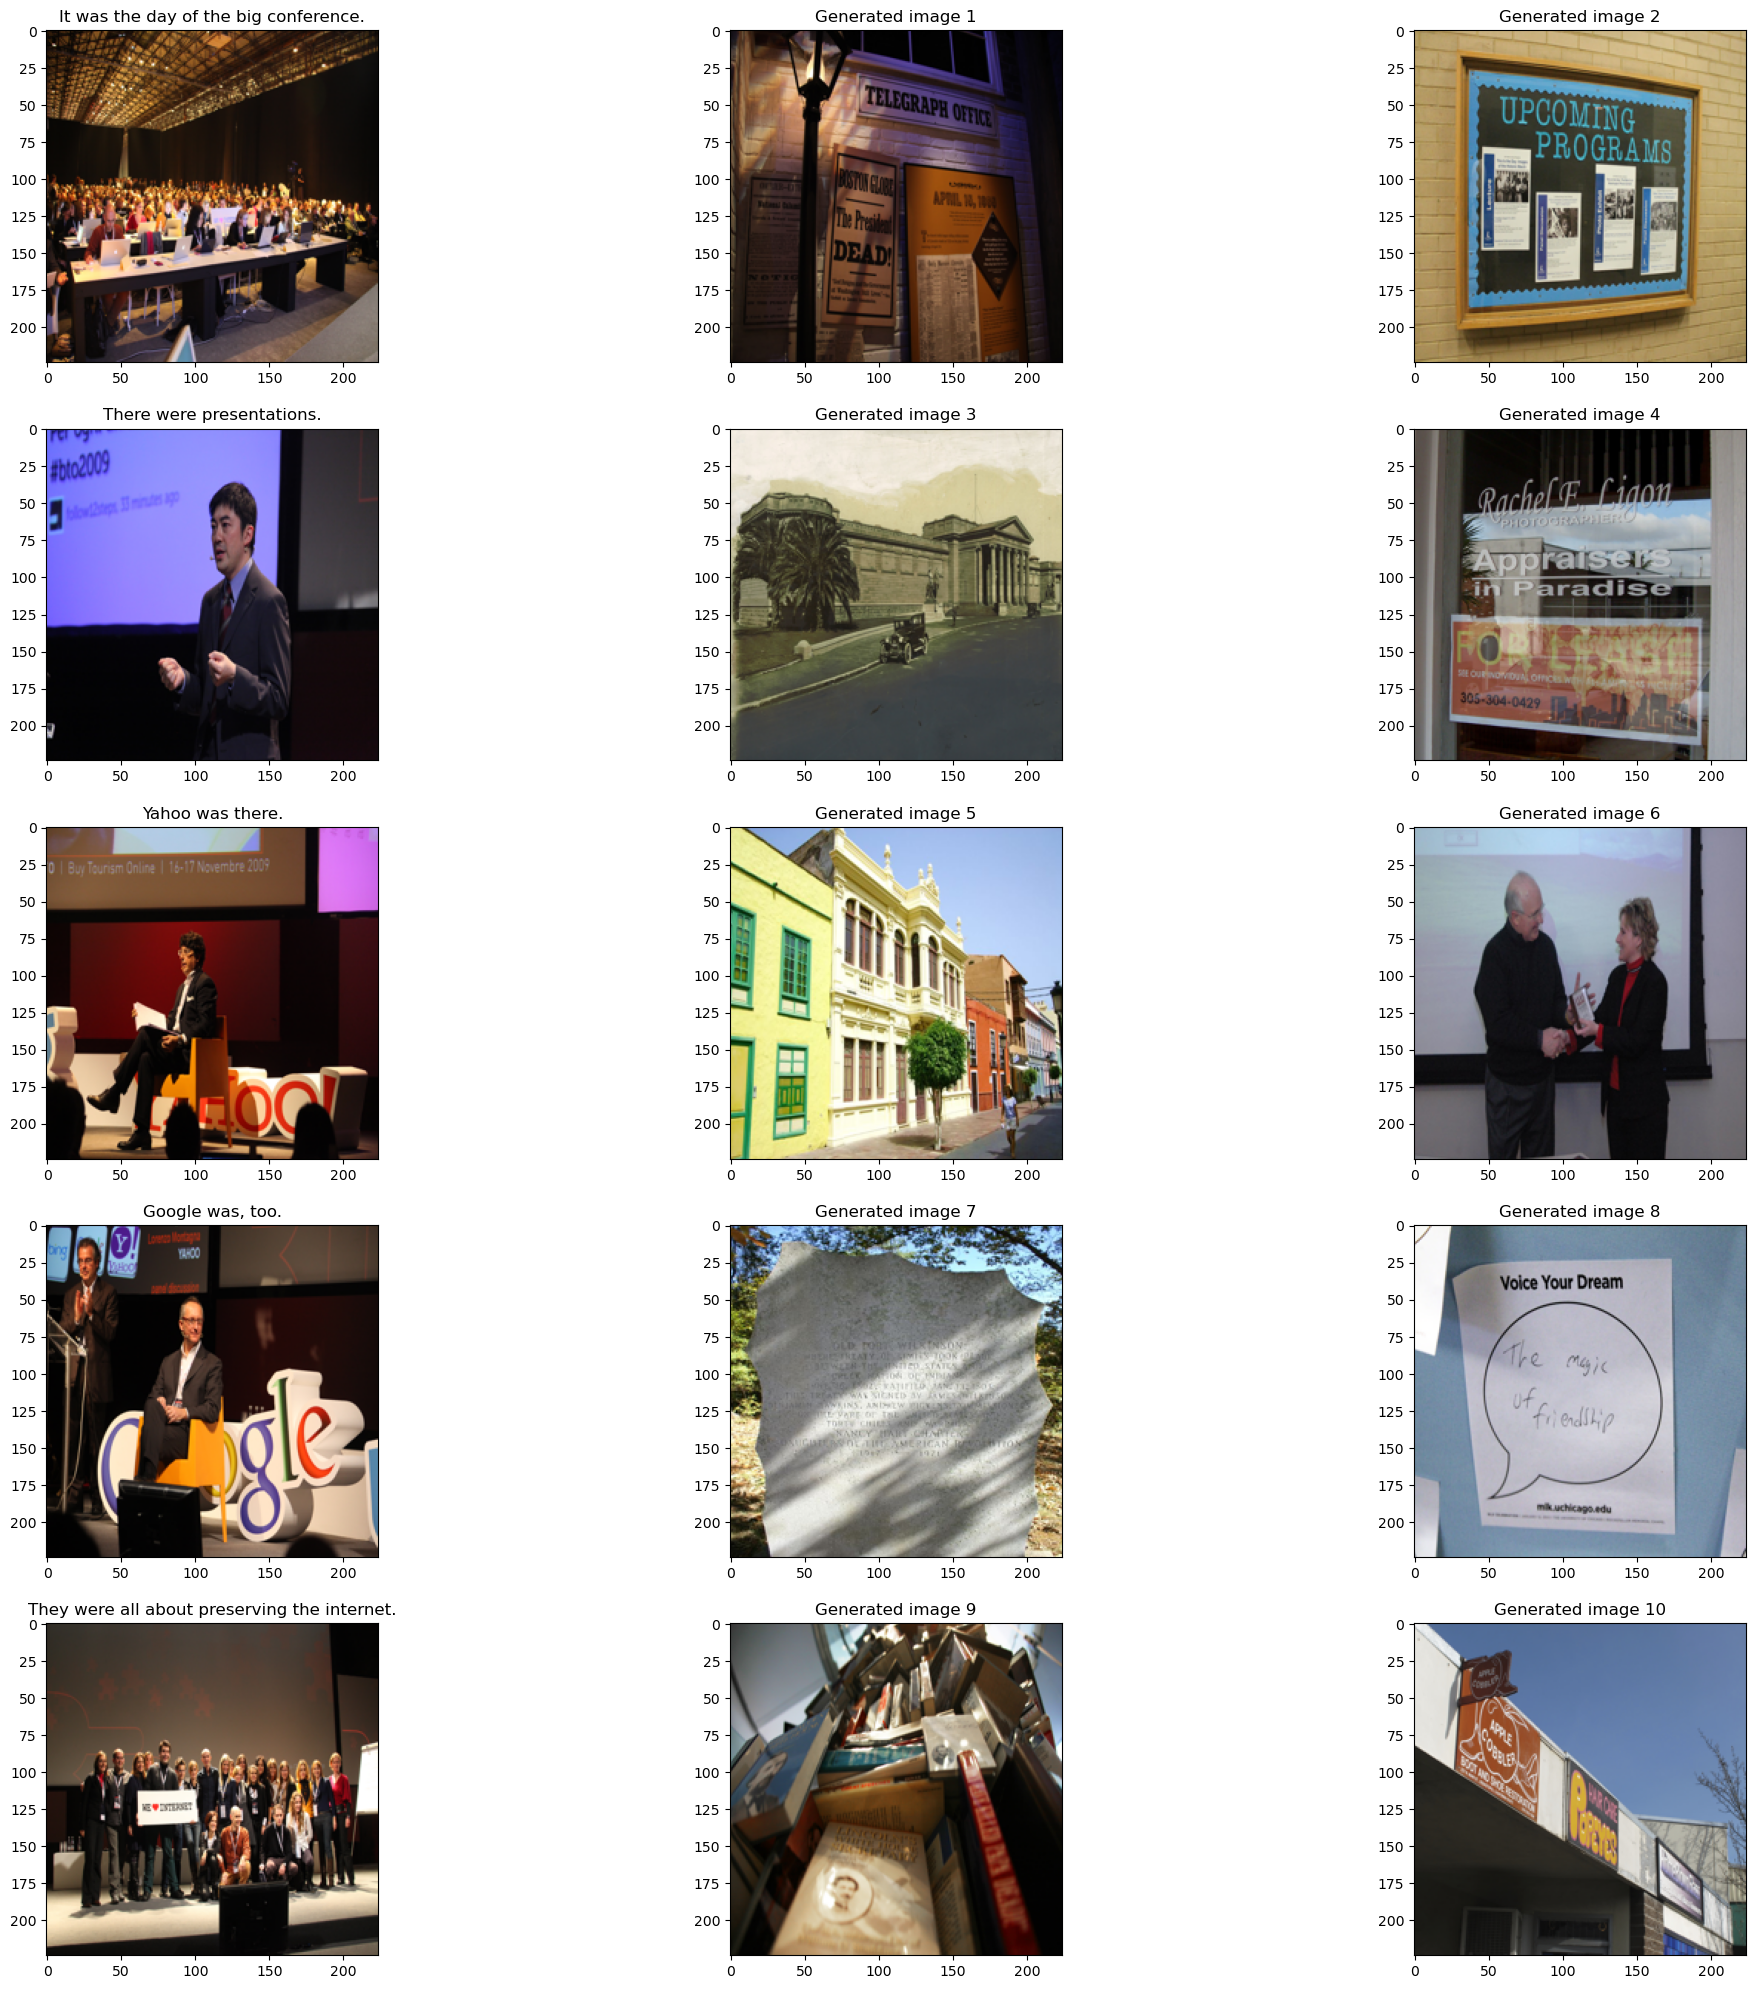

In [93]:
## DISPLAY ONE STORY AND ITS RETRIEVED IMAGE FROM INPUTS WITH 5 CAPTIONS AND 4 IMAGES AT RECALL@10
display_story(5,4,10,5)